#Outline
1. Modified SN Class
2. Overall Setup - What is the data, model, task?
3. Plotting functions- 3D,countour
4. Individual algorithms and how they perform
5. Exercise

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from matplotlib import cm
import matplotlib.colors

from matplotlib import animation, rc
from IPython.display import HTML


In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [ ]:
class SN:

  def __init__(self, w_init, b_init, algo):
    self.w = w_init
    self.b = b_init

    self.w_h = []
    self.b_h = []
    self.e_h = []

    self.algo = algo

  def sigmoid(self, x, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b

    return 1. / (1. + np.exp(-(w*x + b)))


  def error(self, X, Y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    err = 0
    for x, y in zip(X, Y):
      err += 0.5 * (self.sigmoid(x, w, b)-y)**2
    return err

  def grad_w(self, x, y, w=None, b=None):
      if w is None:
        w = self.w
      if b is None:
        b = self.b
      y_pred = self.sigmoid(x, w, b)
      return (y_pred - y) * y_pred * (1 - y_pred) * x

  def grad_b(self, x, y, w=None, b=None):
      if w is None:
        w = self.w
      if b is None:
        b = self.b
      y_pred = self.sigmoid(x, w, b)
      return (y_pred - y) * y_pred * (1 - y_pred)

  def fit(self, X, Y,
          epochs=100, eta = 0.01, gamma=0.9, mini_batch_size=100, eps =1e-8,
          beta=0.9, beta1=0.9, beta2=0.9
          ):
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.X = X
    self.Y = Y

    if self.algo == 'GD':
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x,y)
        self.w -= eta * dw/ X.shape[0]
        self.b -= eta * db/ X.shape[0]
        self.append_log()


    elif self.algo == 'Momentum':
      v_w_prev, v_b_prev = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x,y)
        v_w = gamma * v_w_prev + eta * dw
        v_b = gamma * v_b_prev + eta * db
        self.w -= self.w -v_w
        self.b -= self.b -v_b
        v_w_prev, v_b_prev = v_w, v_b
        self.append_log()

    elif self.algo == 'NAG':
      v_w_prev, v_b_prev = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        v_w = gamma * v_w_prev
        v_b = gamma * v_b_prev
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
          db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
        v_w = gamma * v_w_prev + eta * dw
        v_b = gamma * v_b_prev + eta * db
        self.w -= self.w -v_w
        self.b -= self.b -v_b
        v_w_prev, v_b_prev = v_w, v_b
        self.append_log()



    elif self.algo == 'MiniBatch':
      for i in range(epochs):
        dw, db = 0, 0
        points_seen = 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x,y)
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            self.w -= eta * dw / mini_batch_size
            self.b -= eta * db / mini_batch_size
            self.append_log()
            dw, db = 0, 0


    elif self.algo == 'AdaGrad':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        v_w += dw**2
        v_b += db**2
        self.w -= eta / (np.sqrt(v_w) + eps)*dw
        self.b -= eta / (np.sqrt(v_b) + eps)*db
        self.append_log()

    elif self.algo == 'RMSprop':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        v_w = beta * v_w + (1 - beta) * dw**2
        v_b = beta * v_b + (1 - beta) * db**2
        self.w -= eta / (np.sqrt(v_w) + eps)*dw
        self.b -= eta / (np.sqrt(v_b) + eps)*db
        self.append_log()

    elif self.algo == 'Adam':
      m_w, m_b = 0, 0
      v_w, v_b = 0, 0
      num_updates = 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw = self.grad_w(x, y)
          db = self.grad_b(x, y)
          num_updates += 1
        m_w = beta1 * m_w + (1 - beta1) * dw
        m_b = beta1 * m_b + (1 - beta1) * db
        v_w = beta2 * v_w + (1 - beta2) * dw**2
        v_b = beta2 * v_b + (1 - beta2) * db**2
        m_w_c = m_w / (1 - np.power(beta1, num_updates))
        m_b_c = m_b / (1 - np.power(beta1, num_updates))
        v_w_c = v_w / (1 - np.power(beta2, num_updates))
        v_b_c = v_b / (1 - np.power(beta2, num_updates))
        self.w -= eta / (np.sqrt(v_w_c) + eps)*m_w_c
        self.b -= eta  / (np.sqrt(v_b_c) + eps)*m_b_c
        self.append_log()

  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X, self.Y))





In [ ]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2, 0.9])

algo  = 'GD'

# w_init = -3
# b_init = 4

w_init = -2
b_init = -2

# w_init = -5
# b_init = 4

epochs = 1000
eta = 1

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20
plot_3d = False
plot_2d = True


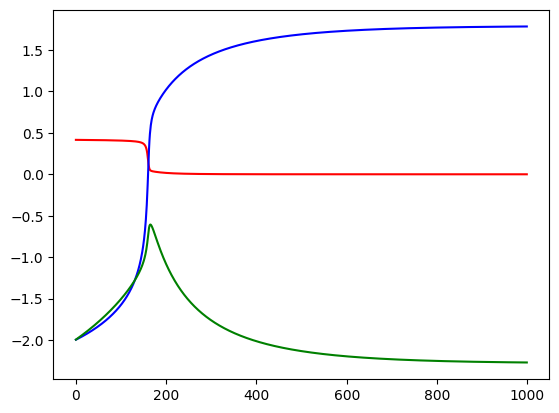

In [ ]:
sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs=epochs, eta=eta)

plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
plt.show()

In [ ]:
def plot_animate_3d(i):
  global line1, line2, title
  i = int(i*(epochs/animation_frames))
  line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line1.set_3d_properties(sn.e_h[:i+1])
  line2.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line2.set_3d_properties(np.zeros(i+1)-1)

  title.set_text('Epoch: {:d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  return line1, line2, title


In [ ]:
if plot_3d:
  W = np.linspace(w_min, w_max, 256)
  B = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, B)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100)
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(WW, BB, Z, rstride=3, cstride=3, alpha=0.5,
                         cmap=cm.coolwarm, linewidth=0, antialiased=False)
  cset = ax.contourf(WW, BB, Z, 25, zdir='z', offset=-1, alpha=0.6,
                     cmap=cm.coolwarm)

  ax.set_xlabel('W')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('B')
  ax.set_ylim(b_min - 1, b_max + 1)
  ax.set_zlabel('Error')
  ax.set_zlim(-1, np.max(Z))
  ax.view_init(elev=25, azim=-75)
  ax.dist = 12

  title = ax.set_title('Epoch 0')


In [ ]:
if plot_3d:
  i = 0

  line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], sn.e_h[:i+1], 'b-o')
  line2, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], np.zeros(i+1)-1, 'g-o')
  anim = animation.FuncAnimation(fig, plot_animate_3d,
                                 frames=animation_frames, interval=50)
  rc('animation', html='jshtml')
  anim



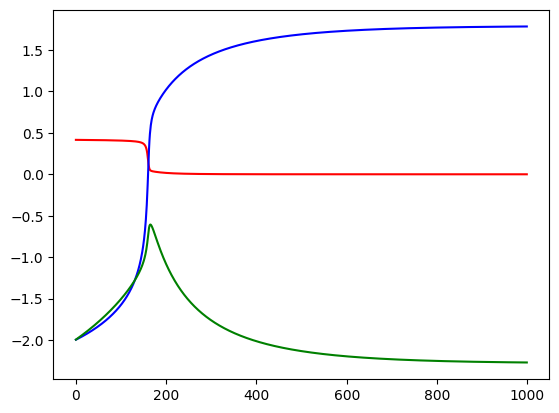

In [ ]:
if plot_2d:
  plt.plot(sn.e_h,'r')
  plt.plot(sn.w_h,'b')
  plt.plot(sn.b_h,'g')
  plt.show()

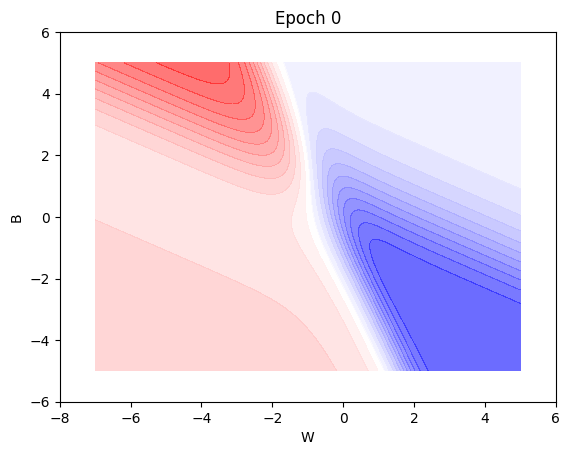

In [68]:
def plot_animate_2d(i):
    i = int(i*(epochs/animation_frames))
    line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    line2.set_data(sn.w_h[:i+1], np.zeros(i+1)-1)
    title.set_text('Epoch: {:d}, Error: {:.4f}'.format(i, sn.e_h[i]))
    return line1, line2, title

if plot_2d:
  W = np.linspace(w_min, w_max, 256)
  B = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, B)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100)
  ax = fig.add_subplot(111)

  ax.set_xlabel('W')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('B')
  ax.set_ylim(b_min - 1, b_max + 1)
  title = ax.set_title('Epoch 0')
  cset = plt.contourf(WW, BB, Z, 25, alpha=0.6, cmap=cm.bwr)
  plt.show()


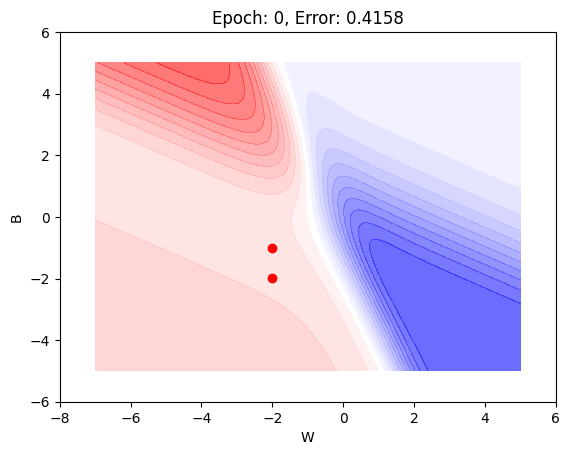

In [70]:

if plot_2d:
    W = np.linspace(w_min, w_max, 256)
    B = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, B)
    Z = sn.error(X, Y, WW, BB)

    fig, ax = plt.subplots(dpi=100)

    ax.set_xlabel('W')
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylabel('B')
    ax.set_ylim(b_min - 1, b_max + 1)
    title = ax.set_title('Epoch 0')
    cset = ax.contourf(WW, BB, Z, 25, alpha=0.6, cmap=cm.bwr)

    i = 0
    line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], 'r-o')
    line2, = ax.plot(sn.w_h[:i+1], np.zeros(i+1)-1, 'r-o')

    anim = animation.FuncAnimation(fig, plot_animate_2d,
                                   frames=animation_frames, interval=50)
    rc('animation', html='jshtml')
    anim


In [71]:
if algo == 'GD':
  print('algo = {}, eta = {}'.format(algo, eta))

elif algo == 'Momentum' or algo == 'NAG':
  print('algo = {}, eta = {}, gamma = {}'.format(algo, eta, gamma))

elif algo == 'MiniBatch':
  print('algo = {}, eta = {}, gamma = {}, mini_batch_size = {}'.format(algo, eta, gamma, mini_batch_size))

elif algo == 'AdaGrad' or algo == 'RMSprop' :
  print('algo = {}, eta = {}, eps = {}'.format(algo, eta, eps))
anim

algo = GD, eta = 1
